In [ ]:
import numpy as np
import pandas as pd
import glob
from skimage.io import imread
from skimage import io
from skimage.color import gray2rgb
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn import datasets, preprocessing, linear_model
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix, classification_report
from mlxtend.plotting import plot_confusion_matrix

In [ ]:
!unzip -q 'Group_7.zip'

Neural Network

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical, plot_model

Comparison

In [ ]:
pip install matplotlib

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
import os

# **Model Arch**

In [ ]:
import os
import tensorflow as tf

In [ ]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras import models, layers

In [ ]:
BATCH_SIZE = 32
IMAGE_SIZE = 224
CHANNELS=3

In [ ]:
train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/Group_7/train",
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 2150 files belonging to 5 classes.


In [ ]:
test_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/Group_7/test",
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 250 files belonging to 5 classes.


In [ ]:
class_names= train_dataset.class_names if train_dataset.class_names==test_dataset.class_names else 'Classes don\'t match among train,test, and validation dataset'
class_names

['flagpole', 'gasmask', 'gondola', 'hourglass', 'lampshade']

In [ ]:
for image_batch, labels_batch in train_dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())

(32, 224, 224, 3)
[1 4 3 0 0 0 2 4 4 3 3 2 3 2 2 2 0 1 1 2 3 4 1 2 1 4 0 3 3 2 0 3]


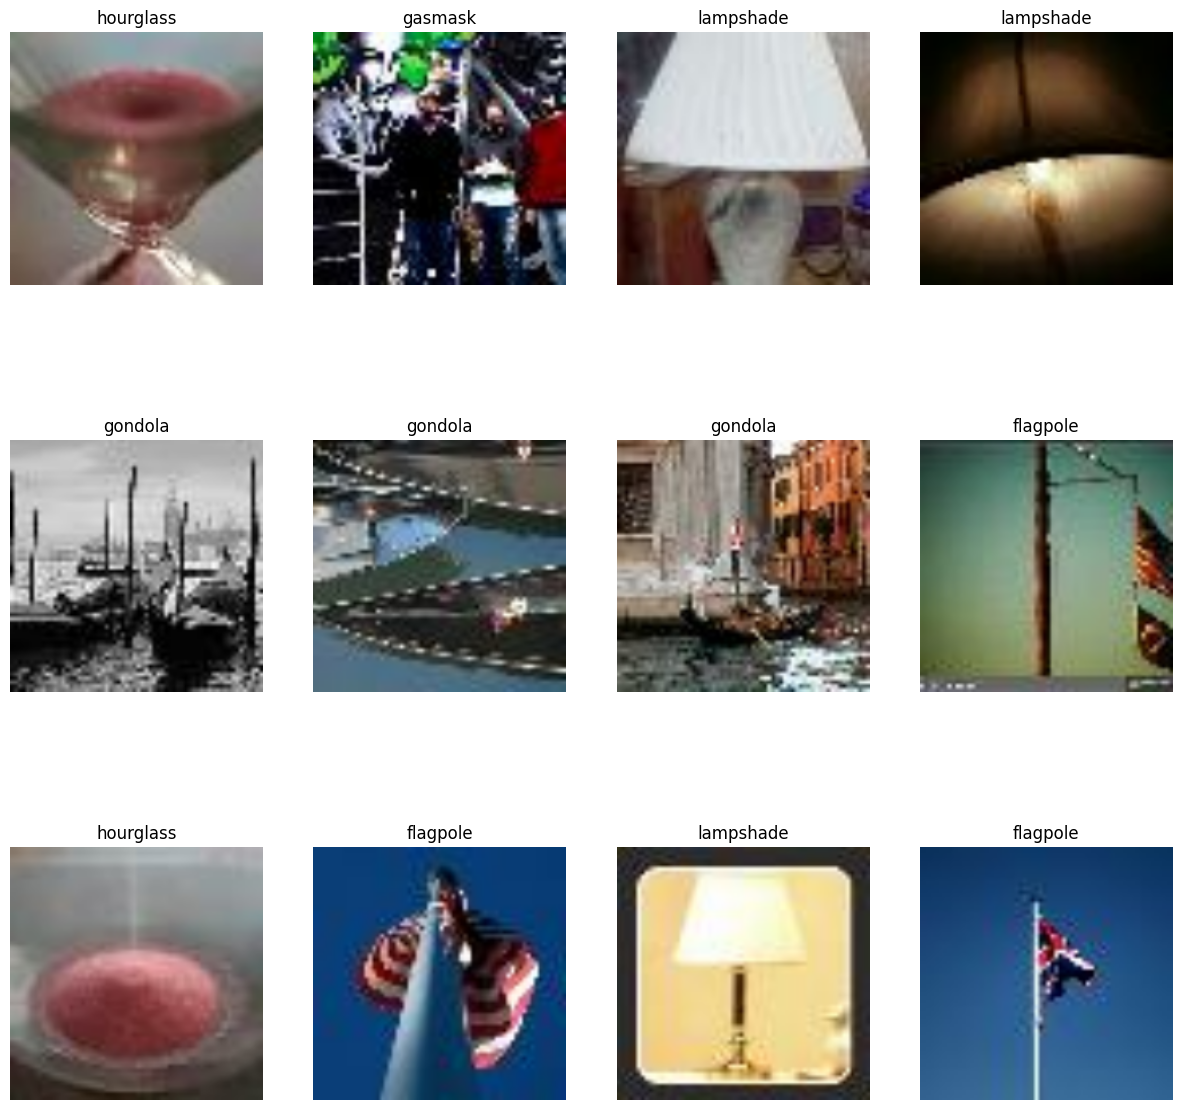

In [ ]:
plt.figure(figsize=(15, 15))
for image_batch, labels_batch in train_dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

In [ ]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.2, shuffle=True, shuffle_size=10000):
    assert (train_split  + val_split) == 1

    ds_size = len(ds)

    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)

    train_size = int(train_split * ds_size)
    # val_size = int(val_split * ds_size)

    train_ds = ds.take(train_size)
    # val_ds = ds.skip(train_size).take(val_size)
    val_ds = ds.skip(train_size)

    return train_ds, val_ds

In [ ]:
train_ds, val_ds = get_dataset_partitions_tf(train_dataset)

In [ ]:
len(train_ds),len(val_ds),len(test_dataset)

(54, 14, 8)

# *Cacha, Shuffle, prefetch*

In [ ]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_dataset.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

# Creating a Layer for Resizing and Normalization

In [ ]:
resize_and_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1.0/255),
])

In [ ]:
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])


## Apply data aug to training data

In [ ]:
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

In [ ]:
save_dir = '/content/Model0'
if not os.path.exists(save_dir):
   os.makedirs(save_dir)

checkpoint_filepath = os.path.join(save_dir, 'checkpoint-{epoch:02d}-{val_loss:.2f}.h5')


model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
filepath=checkpoint_filepath,
save_weights_only=False,
monitor='val_accuracy',
mode='max',
save_best_only=True)

# **ALEXNET FROM SCRATCH___**

In [ ]:
from keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization,Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D,MaxPool2D
from keras.initializers import glorot_uniform
from keras.models import Sequential, Model,load_model
import itertools

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, ReLU, Add, GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model

# Define the Residual Block
def residual_block(x, filters, stride=1):
    shortcut = x

    # First convolution layer
    x = Conv2D(filters, kernel_size=(3, 3), strides=stride, padding='same')(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)

    # Second convolution layer
    x = Conv2D(filters, kernel_size=(3, 3), strides=1, padding='same')(x)
    x = BatchNormalization()(x)

    # Adjusting dimensions of the shortcut connection if needed
    if stride != 1 or shortcut.shape[-1] != filters:
        shortcut = Conv2D(filters, kernel_size=(1, 1), strides=stride, padding='valid')(shortcut)
        shortcut = BatchNormalization()(shortcut)

    # Adding shortcut to the main path
    x = Add()([x, shortcut])
    x = ReLU()(x)
    return x

# Define the Alexnet model
def build_alexnet(input_shape, num_classes, num_blocks, num_filters):
    input_layer = Input(shape=input_shape)

    x = Conv2D(num_filters, kernel_size=(5, 5), strides=2, padding='same')(input_layer)
    x = BatchNormalization()(x)
    x = ReLU()(x)

    x = MaxPooling2D(pool_size=(3, 3), strides=2, padding='same')(x)

    # Building the residual blocks
    for i in range(3):
        stride = 1 if i == 0 else 2  # First block uses stride 1, the rest use stride 2
        x = residual_block(x, filters=num_filters, stride=stride)

    x = GlobalAveragePooling2D()(x)
    x = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=input_layer, outputs=x)

    return model

input_shape = (224, 224, 3)
num_classes = 5

num_blocks = 3
num_filters = 64

alexnet_model = build_alexnet(input_shape, num_classes, num_blocks, num_filters)

alexnet_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 112, 112, 64)         4864      ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 112, 112, 64)         256       ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 re_lu (ReLU)                (None, 112, 112, 64)         0         ['batch_normalization[0][0

In [ ]:
alexnet_model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [ ]:
history = alexnet_model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=10,
     callbacks=[model_checkpoint_callback]
)

Epoch 1/10
54/54 [==============================] - 12s 229ms/step - loss: 1.0368 - accuracy: 0.5984 - val_loss: 2.5707 - val_accuracy: 0.3460
Epoch 2/10
54/54 [==============================] - 12s 228ms/step - loss: 1.0223 - accuracy: 0.6019 - val_loss: 1.3267 - val_accuracy: 0.5402
Epoch 3/10
54/54 [==============================] - 12s 222ms/step - loss: 1.0008 - accuracy: 0.6100 - val_loss: 2.0078 - val_accuracy: 0.3504
Epoch 4/10
54/54 [==============================] - 12s 230ms/step - loss: 0.9875 - accuracy: 0.6140 - val_loss: 1.2156 - val_accuracy: 0.5000
Epoch 5/10
54/54 [==============================] - 12s 228ms/step - loss: 0.9950 - accuracy: 0.6100 - val_loss: 2.6799 - val_accuracy: 0.3906
Epoch 6/10
54/54 [==============================] - 12s 222ms/step - loss: 0.9600 - accuracy: 0.6302 - val_loss: 1.3816 - val_accuracy: 0.4554
Epoch 7/10
54/54 [==============================] - 13s 231ms/step - loss: 0.9354 - accuracy: 0.6400 - val_loss: 0.9879 - val_accuracy: 0.6205

In [ ]:
new_model1=tf.keras.models.load_model("/content/Model0/checkpoint-09-0.99.h5")

In [ ]:
#scores = history.evaluate(test_ds)
scores = new_model1.evaluate(test_ds)
test_loss, test_accuracy = alexnet_model.evaluate(test_ds)

8/8 [==============================] - 0s 23ms/step - loss: 1.6540 - accuracy: 0.3920


8/8 [==============================] - 1s 21ms/step
              precision    recall  f1-score   support

    flagpole       0.21      0.20      0.20        50
     gasmask       0.25      0.06      0.10        50
     gondola       0.20      0.24      0.22        50
   hourglass       0.24      0.38      0.29        50
   lampshade       0.17      0.18      0.18        50

    accuracy                           0.21       250
   macro avg       0.22      0.21      0.20       250
weighted avg       0.22      0.21      0.20       250



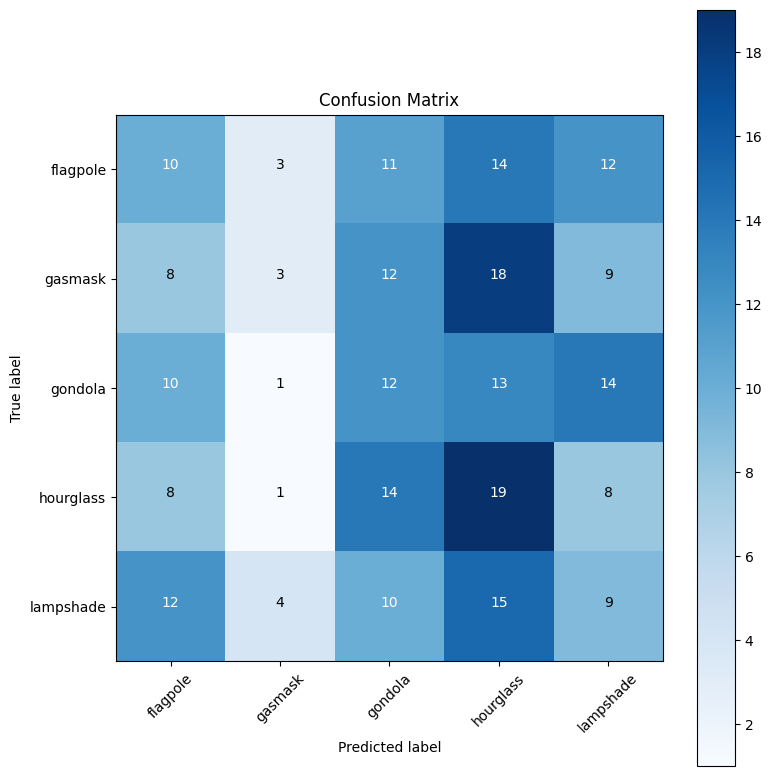

In [ ]:
import numpy as np
import itertools
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.utils import shuffle

# Assuming you have the true labels (true_labels0) and test dataset (test_ds) available
predictions0 = new_model1.predict(test_ds)
predicted_labels0 = np.argmax(predictions0, axis=1)
true_labels0 = np.concatenate([y for x, y in test_ds], axis=0)

# Ensure true_labels0 and predicted_labels0 have the same length
true_labels0, predicted_labels0 = shuffle(true_labels0, predicted_labels0, random_state=42)

# Define your class names (if available)
class_names = ['flagpole', 'gasmask', 'gondola', 'hourglass', 'lampshade']

# Compute confusion matrix
confusion_mtx0 = confusion_matrix(true_labels0, predicted_labels0)

# Print classification report
print(classification_report(true_labels0, predicted_labels0, target_names=class_names))

# Plot the confusion matrix
def plot_confusion_matrix(cm, class_names):
    plt.figure(figsize=(8, 8))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.colorbar()
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names, rotation=45)
    plt.yticks(tick_marks, class_names)

    fmt = 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Plot the confusion matrix
plot_confusion_matrix(confusion_mtx0, class_names)
plt.show()


In [ ]:
# Initialize variables to store aggregate metrics
sensitivity_sum = 0
specificity_sum = 0
ppv_sum = 0
npv_sum = 0

# Iterate over each class
for class_label in range(confusion_mtx0.shape[0]):
    tp = confusion_mtx0[class_label, class_label]
    fn = np.sum(confusion_mtx0[class_label, :]) - tp
    fp = np.sum(confusion_mtx0[:, class_label]) - tp
    tn = np.sum(confusion_mtx0) - (tp + fn + fp)

    sensitivity = tp / (tp + fn)
    specificity = tn / (tn + fp)
    ppv = tp / (tp + fp)
    npv = tn / (tn + fn)

    sensitivity_sum += sensitivity
    specificity_sum += specificity
    ppv_sum += ppv
    npv_sum += npv

# Calculate average metrics across all classes
num_classes = confusion_mtx0.shape[0]
sensitivity_avg = sensitivity_sum / num_classes
specificity_avg = specificity_sum / num_classes
ppv_avg = ppv_sum / num_classes
npv_avg = npv_sum / num_classes

# Print or display the aggregate metrics
print("Sensitivity (Average):", sensitivity_avg)
print("Specificity (Average):", specificity_avg)
print("PPV (Positive Predictive Value) (Average):", ppv_avg)
print("NPV (Negative Predictive Value) (Average):", npv_avg)

Sensitivity (Average): 0.21200000000000002
Specificity (Average): 0.8030000000000002
PPV (Positive Predictive Value) (Average): 0.215061283206531
NPV (Negative Predictive Value) (Average): 0.8034382140127405


In [ ]:
show={}
show['ALEXNET'] = scores[1]

In [ ]:
history.history.keys()
history.history

{'loss': [1.036806344985962,
  1.0223256349563599,
  1.0008424520492554,
  0.9875091910362244,
  0.9950426816940308,
  0.95998215675354,
  0.9354188442230225,
  0.9351403117179871,
  0.9157127737998962,
  0.9052353501319885],
 'accuracy': [0.5983796119689941,
  0.6018518805503845,
  0.6099537014961243,
  0.6140046119689941,
  0.6099537014961243,
  0.6302083134651184,
  0.6400462985038757,
  0.6400462985038757,
  0.6545138955116272,
  0.6435185074806213],
 'val_loss': [2.5706593990325928,
  1.3267089128494263,
  2.0078468322753906,
  1.2155767679214478,
  2.6798949241638184,
  1.3816421031951904,
  0.9879169464111328,
  1.0817633867263794,
  0.9937963485717773,
  1.4987258911132812],
 'val_accuracy': [0.3459821343421936,
  0.5401785969734192,
  0.3504464328289032,
  0.5,
  0.390625,
  0.4553571343421936,
  0.6205357313156128,
  0.5803571343421936,
  0.625,
  0.4084821343421936]}

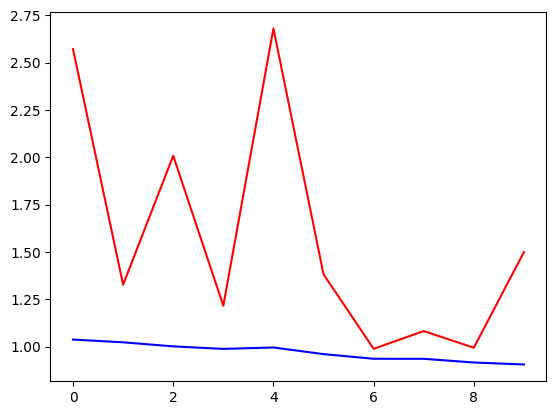

In [ ]:
plt.plot(range(10), history.history["loss"][:10], 'b')
plt.plot(range(10), history.history["val_loss"][:10], 'r')
plt.show()

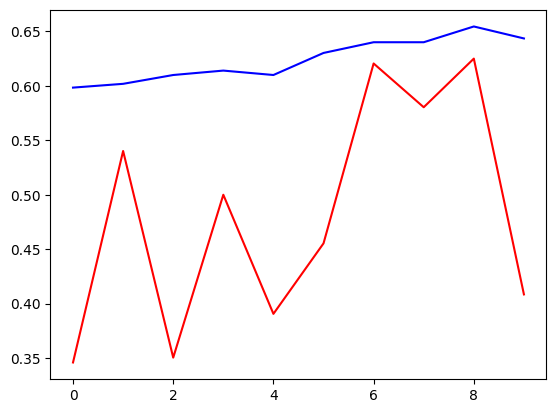

In [ ]:
plt.plot(range(10), history.history["accuracy"][:10], 'b')
plt.plot(range(10), history.history["val_accuracy"][:10], 'r')
plt.show()

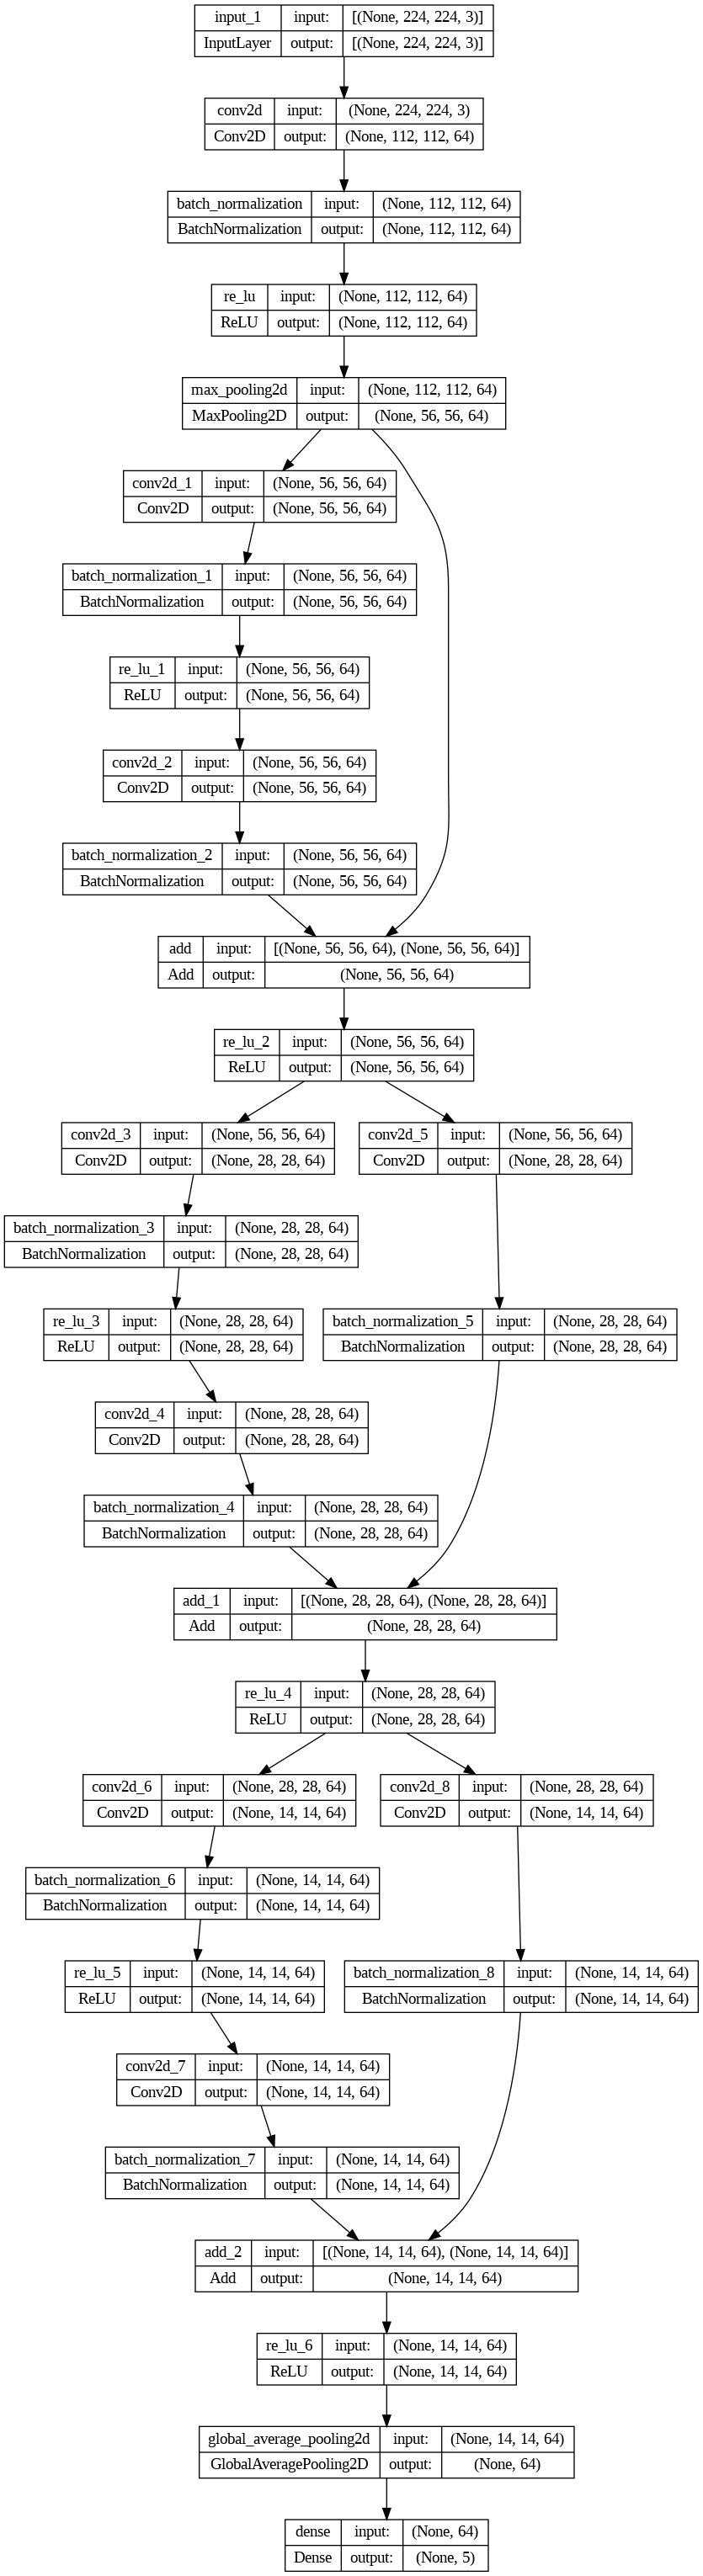

In [ ]:
plot_model(alexnet_model, show_shapes=True)

In [ ]:
save_dir = '/content/Model1'
if not os.path.exists(save_dir):
   os.makedirs(save_dir)

checkpoint_filepath = os.path.join(save_dir, 'checkpoint-{epoch:02d}-{val_loss:.2f}.h5')


model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
filepath=checkpoint_filepath,
save_weights_only=False,
monitor='val_accuracy',
mode='max',
save_best_only=True)

## RESNET FROM SCRATCH___

In [ ]:
from keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization,Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D,MaxPool2D
from keras.initializers import glorot_uniform
from keras.models import Sequential, Model,load_model
import itertools

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, ReLU, Add, GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model

# Define the Residual Block
def residual_block(x, filters, stride=1):
    shortcut = x

    # First convolution layer
    x = Conv2D(filters, kernel_size=(3, 3), strides=stride, padding='same')(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)

    # Second convolution layer
    x = Conv2D(filters, kernel_size=(3, 3), strides=1, padding='same')(x)
    x = BatchNormalization()(x)

    # Adjusting dimensions of the shortcut connection if needed
    if stride != 1 or shortcut.shape[-1] != filters:
        shortcut = Conv2D(filters, kernel_size=(1, 1), strides=stride, padding='valid')(shortcut)
        shortcut = BatchNormalization()(shortcut)

    # Adding shortcut to the main path
    x = Add()([x, shortcut])
    x = ReLU()(x)
    return x

# Define the alexNet model
def build_resnet(input_shape, num_classes, num_blocks, num_filters):
    input_layer = Input(shape=input_shape)

    x = Conv2D(num_filters, kernel_size=(5, 5), strides=2, padding='same')(input_layer)
    x = BatchNormalization()(x)
    x = ReLU()(x)

    x = MaxPooling2D(pool_size=(3, 3), strides=2, padding='same')(x)

    # Building the residual blocks
    for i in range(3):
        stride = 1 if i == 0 else 2  # First block uses stride 1, the rest use stride 2
        x = residual_block(x, filters=num_filters, stride=stride)

    x = GlobalAveragePooling2D()(x)
    x = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=input_layer, outputs=x)

    return model

input_shape = (224, 224, 3)
num_classes = 5

num_blocks = 3
num_filters = 64

resnet_model = build_resnet(input_shape, num_classes, num_blocks, num_filters)

resnet_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv2d_9 (Conv2D)           (None, 112, 112, 64)         4864      ['input_2[0][0]']             
                                                                                                  
 batch_normalization_9 (Bat  (None, 112, 112, 64)         256       ['conv2d_9[0][0]']            
 chNormalization)                                                                                 
                                                                                                  
 re_lu_7 (ReLU)              (None, 112, 112, 64)         0         ['batch_normalization_9[

In [ ]:
resnet_model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [ ]:
history1 = resnet_model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=10,
     callbacks=[model_checkpoint_callback]
)

Epoch 1/10
54/54 [==============================] - 18s 233ms/step - loss: 1.2374 - accuracy: 0.5150 - val_loss: 3.6988 - val_accuracy: 0.2277


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 2/10
54/54 [==============================] - 13s 231ms/step - loss: 1.1331 - accuracy: 0.5602 - val_loss: 2.6221 - val_accuracy: 0.2567
Epoch 3/10
54/54 [==============================] - 12s 224ms/step - loss: 1.0819 - accuracy: 0.5747 - val_loss: 1.7718 - val_accuracy: 0.4330
Epoch 4/10
54/54 [==============================] - 12s 221ms/step - loss: 1.0576 - accuracy: 0.5862 - val_loss: 1.9058 - val_accuracy: 0.3125
Epoch 5/10
54/54 [==============================] - 12s 229ms/step - loss: 1.0263 - accuracy: 0.5972 - val_loss: 1.2448 - val_accuracy: 0.5312
Epoch 6/10
54/54 [==============================] - 12s 222ms/step - loss: 0.9996 - accuracy: 0.6169 - val_loss: 2.1810 - val_accuracy: 0.3036
Epoch 7/10
54/54 [==============================] - 20s 380ms/step - loss: 0.9891 - accuracy: 0.6088 - val_loss: 1.1567 - val_accuracy: 0.5513
Epoch 8/10
54/54 [==============================] - 12s 225ms/step - loss: 0.9910 - accuracy: 0.6100 - val_loss: 1.2988 - val_accuracy: 0.4420

In [ ]:
new_model2=tf.keras.models.load_model("/content/Model1/checkpoint-05-1.32.h5")

In [ ]:
#scores = history.evaluate(test_ds)
scores1 = new_model2.evaluate(test_ds)
test_loss, test_accuracy = resnet_model.evaluate(test_ds)

In [ ]:
predictions0 = new_model2.predict(test_ds)
predicted_labels0 = np.argmax(predictions0, axis=1)
true_labels0 = np.concatenate([y for x, y in test_ds], axis=0)
confusion_mtx0 = confusion_matrix(true_labels0, predicted_labels0)
def plot_confusion_matrix(cm, class_names):
    plt.figure(figsize=(8, 8))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.colorbar()
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names, rotation=45)
    plt.yticks(tick_marks, class_names)

    fmt = 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Define your class names (if available)
class_names = ['flagpole', 'gasmask', 'gondola', 'hourglass', 'lampshade']

# Plot the confusion matrix
plot_confusion_matrix(confusion_mtx0, class_names)
plt.show()

In [ ]:
from sklearn.metrics import classification_report

# Assuming you have loaded your model and made predictions as in the previous code

# Generate a classification report
report = classification_report(true_labels0, predicted_labels0, target_names=['flagpole', 'gasmask', 'gondola', 'hourglass', 'lampshade'])

# Print or display the classification report
print(report)

In [ ]:
# Initialize variables to store aggregate metrics
sensitivity_sum = 0
specificity_sum = 0
ppv_sum = 0
npv_sum = 0

# Iterate over each class
for class_label in range(confusion_mtx0.shape[0]):
    tp = confusion_mtx0[class_label, class_label]
    fn = np.sum(confusion_mtx0[class_label, :]) - tp
    fp = np.sum(confusion_mtx0[:, class_label]) - tp
    tn = np.sum(confusion_mtx0) - (tp + fn + fp)

    sensitivity = tp / (tp + fn)
    specificity = tn / (tn + fp)
    ppv = tp / (tp + fp)
    npv = tn / (tn + fn)

    sensitivity_sum += sensitivity
    specificity_sum += specificity
    ppv_sum += ppv
    npv_sum += npv

# Calculate average metrics across all classes
num_classes = confusion_mtx0.shape[0]
sensitivity_avg = sensitivity_sum / num_classes
specificity_avg = specificity_sum / num_classes
ppv_avg = ppv_sum / num_classes
npv_avg = npv_sum / num_classes

# Print or display the aggregate metrics
print("Sensitivity (Average):", sensitivity_avg)
print("Specificity (Average):", specificity_avg)
print("PPV (Positive Predictive Value) (Average):", ppv_avg)
print("NPV (Negative Predictive Value) (Average):", npv_avg)

# --------------------------------------------------------------------------------------

In [ ]:
show={}
show['Resnet50'] = scores1[1]

In [ ]:
#history1.history.keys()
history1.history

In [ ]:
plt.plot(range(10), history1.history["loss"][:10], 'b')
plt.plot(range(10), history1.history["val_loss"][:10], 'r')
plt.show()

In [ ]:
plt.plot(range(10), history1.history["accuracy"][:10], 'b')
plt.plot(range(10), history1.history["val_accuracy"][:10], 'r')
plt.show()

In [ ]:
tf.keras.utils.plot_model(resnet_model, show_shapes=True)

## InceptionNet!

In [ ]:
save_dir = '/content/Model2'
if not os.path.exists(save_dir):
   os.makedirs(save_dir)

checkpoint_filepath = os.path.join(save_dir, "checkpoint-{epoch:02d}-{val_loss:.2f}.h5")

model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
filepath=checkpoint_filepath,
save_weights_only=False,
monitor='val_accuracy',
mode='max',
save_best_only=True)

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Concatenate, Flatten, Dense
from tensorflow.keras.models import Model

# Define a custom Inception-like block
def inception_block(x, filters):
    # 1x1 Convolution
    conv1x1 = Conv2D(filters[0], (1, 1), padding='same', activation='relu')(x)

    # 1x1 Convolution followed by 3x3 Convolution
    conv3x3_reduce = Conv2D(filters[1], (1, 1), padding='same', activation='relu')(x)
    conv3x3 = Conv2D(filters[2], (3, 3), padding='same', activation='relu')(conv3x3_reduce)

    # 1x1 Convolution followed by 5x5 Convolution
    conv5x5_reduce = Conv2D(filters[3], (1, 1), padding='same', activation='relu')(x)
    conv5x5 = Conv2D(filters[4], (5, 5), padding='same', activation='relu')(conv5x5_reduce)

    # 3x3 Max Pooling followed by 1x1 Convolution
    pool = MaxPooling2D((3, 3), strides=(1, 1), padding='same')(x)
    pool_proj = Conv2D(filters[5], (1, 1), padding='same', activation='relu')(pool)

    # Concatenate all branches
    output = Concatenate(axis=-1)([conv1x1, conv3x3, conv5x5, pool_proj])
    return output

# Define the custom InceptionNet model
def build_inception_net(input_shape, num_classes):
    input_layer = Input(shape=input_shape)

    x = Conv2D(64, (7, 7), strides=2, padding='same', activation='relu')(input_layer)
    x = MaxPooling2D((3, 3), strides=2, padding='same')(x)

    # Build the custom inception-like blocks
    x = inception_block(x, [64, 128, 128, 32, 32, 32])
    x = inception_block(x, [128, 192, 192, 96, 96, 64])

    x = MaxPooling2D((3, 3), strides=2, padding='same')(x)

    # Flatten and add a Dense layer for classification
    x = Flatten()(x)
    x = Dense(512, activation='relu')(x)

    # Output layer for classification
    output_layer = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=input_layer, outputs=output_layer)

    return model

# Define input shape and number of classes
input_shape = (224, 224, 3)
num_classes = 5

# Build the custom InceptionNet model
inception_model = build_inception_net(input_shape, num_classes)

# Display model summary
inception_model.summary()

In [ ]:
inception_model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [ ]:
history2 =inception_model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=10,
    callbacks=[model_checkpoint_callback]
)

In [ ]:
new_model3=tf.keras.models.load_model("/content/Model2/checkpoint-10-0.93.h5")

In [ ]:
scores2 = new_model3.evaluate(test_ds)


#aggregate metrics for InceptionNet

In [ ]:
predictions = new_model3.predict(test_ds)

In [ ]:
predicted_labels2 = np.argmax(predictions, axis=1)

In [ ]:
true_labels = np.concatenate([y for x, y in test_ds], axis=0)

In [ ]:
confusion_mtx = confusion_matrix(true_labels, predicted_labels2)

In [ ]:
def plot_confusion_matrix(cm, class_names):
    plt.figure(figsize=(8, 8))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.colorbar()
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names, rotation=45)
    plt.yticks(tick_marks, class_names)

    fmt = 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Define your class names (if available)
class_names = ['TP', 'FP']

# Plot the confusion matrix
plot_confusion_matrix(confusion_mtx, class_names)
plt.show()


In [ ]:
from sklearn.metrics import classification_report

# Assuming you have loaded your model and made predictions as in the previous code

# Generate a classification report
report = classification_report(true_labels, predicted_labels2, target_names=["Class 0", "Class 1", "Class 2","Class 3","Class 4"])

# Print or display the classification report
print(report)

In [ ]:
# Initialize variables to store aggregate metrics
sensitivity_sum = 0
specificity_sum = 0
ppv_sum = 0
npv_sum = 0

# Iterate over each class
for class_label in range(confusion_mtx.shape[0]):
    tp = confusion_mtx[class_label, class_label]
    fn = np.sum(confusion_mtx[class_label, :]) - tp
    fp = np.sum(confusion_mtx[:, class_label]) - tp
    tn = np.sum(confusion_mtx) - (tp + fn + fp)

    sensitivity = tp / (tp + fn)
    specificity = tn / (tn + fp)
    ppv = tp / (tp + fp)
    npv = tn / (tn + fn)

    sensitivity_sum += sensitivity
    specificity_sum += specificity
    ppv_sum += ppv
    npv_sum += npv

# Calculate average metrics across all classes
num_classes = confusion_mtx.shape[0]
sensitivity_avg = sensitivity_sum / num_classes
specificity_avg = specificity_sum / num_classes
ppv_avg = ppv_sum / num_classes
npv_avg = npv_sum / num_classes

# Print or display the aggregate metrics
print("Sensitivity (Average):", sensitivity_avg)
print("Specificity (Average):", specificity_avg)
print("PPV (Positive Predictive Value) (Average):", ppv_avg)
print("NPV (Negative Predictive Value) (Average):", npv_avg)

# ------------------------------------------------------------------------------------------------------

In [ ]:
show['InceptionNet'] = scores2[1]

In [ ]:
# history2.history.keys()
history2.history

In [ ]:
plt.plot(range(10), history2.history["loss"][:10], 'b')
plt.plot(range(10), history2.history["val_loss"][:10], 'r')
plt.show()

In [ ]:
plt.plot(range(10), history2.history["accuracy"][:10], 'b')
plt.plot(range(10), history2.history["val_accuracy"][:10], 'r')
plt.show()

In [ ]:
tf.keras.utils.plot_model(inception_model, show_shapes=True)

# Custom Model

In [ ]:
save_dir = '/content/Model3'
if not os.path.exists(save_dir):
   os.makedirs(save_dir)

checkpoint_filepath = os.path.join(save_dir, "checkpoint-{epoch:02d}-{val_loss:.2f}.h5")

model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
filepath=checkpoint_filepath,
save_weights_only=False,
monitor='val_accuracy',
mode='max',
save_best_only=True)

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Concatenate, Flatten, Dense
from tensorflow.keras.models import Model

# Define a custom Inception-like block with more flexibility
def custom_inception_block(x, filters):
    branch_1x1 = Conv2D(filters[0], (1, 1), padding='same', activation='relu')(x)

    branch_3x3 = Conv2D(filters[1], (1, 1), padding='same', activation='relu')(x)
    branch_3x3 = Conv2D(filters[2], (3, 3), padding='same', activation='relu')(branch_3x3)

    branch_5x5 = Conv2D(filters[3], (1, 1), padding='same', activation='relu')(x)
    branch_5x5 = Conv2D(filters[4], (5, 5), padding='same', activation='relu')(branch_5x5)

    branch_pool = MaxPooling2D((3, 3), strides=(1, 1), padding='same')(x)
    branch_pool = Conv2D(filters[5], (1, 1), padding='same', activation='relu')(branch_pool)

    output = Concatenate(axis=-1)([branch_1x1, branch_3x3, branch_5x5, branch_pool])
    return output

# Define a custom InceptionNet model with additional customization
def build_custom_inception_net(input_shape, num_classes, num_blocks=2, num_filters_per_block=None):
    if num_filters_per_block is None:
        num_filters_per_block = [[64, 128, 128, 32, 32, 32]] * num_blocks

    input_layer = Input(shape=input_shape)

    x = Conv2D(64, (7, 7), strides=2, padding='same', activation='relu')(input_layer)
    x = MaxPooling2D((3, 3), strides=2, padding='same')(x)

    # Build custom Inception-like blocks
    for filters in num_filters_per_block:
        x = custom_inception_block(x, filters)

    x = MaxPooling2D((3, 3), strides=2, padding='same')(x)

    # Flatten and add a Dense layer for classification
    x = Flatten()(x)
    x = Dense(512, activation='relu')(x)

    # Output layer for classification
    output_layer = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=input_layer, outputs=output_layer)

    return model

# Define input shape and number of classes
input_shape = (224, 224, 3)
num_classes = 5

# Customize the architecture by specifying num_blocks and num_filters_per_block
custom_inception_model = build_custom_inception_net(
    input_shape, num_classes, num_blocks=3, num_filters_per_block=[
        [64, 128, 128, 32, 32, 32],
        [128, 192, 192, 64, 64, 64],
        [192, 128, 128, 96, 96, 96]
    ])

# Display model summary
custom_inception_model.summary()

In [ ]:
custom_inception_model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [ ]:
history3 =custom_inception_model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=10,
    callbacks=[model_checkpoint_callback]
)

In [ ]:
new_model4=tf.keras.models.load_model("/content/Model3/checkpoint-10-0.99.h5")

In [ ]:
scores3 = new_model4.evaluate(test_ds)

In [ ]:
show['Custom Model'] = scores3[1]

-
-
-
-
-
## Predicting image labels by using resnet I have used earlier (RESNET50)

In [ ]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

In [ ]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(len(images)):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))

        predicted_class, confidence = predict(new_model1, images[i].numpy())
        actual_class = class_names[labels[i]]

        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")

        plt.axis("off")

### Predicting image labels by using resnet I have used earlier (InceptionNet)

In [ ]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))

        predicted_class, confidence = predict(new_model3, images[i].numpy())
        actual_class = class_names[labels[i]]

        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")

        plt.axis("off")

--
--
# COMparison GRAphs

In [ ]:
import seaborn as sns
import numpy as np  # Ensure numpy is imported for np.arange

colors = ["red", "green", "orange", "purple"]

# Correctly evaluate scores for all models, including "ALEXNET":
scores = alexnet_model.evaluate(test_ds)
show['ALEXNET'] = scores[1]

scores1 = resnet_model.evaluate(test_ds)
show['Resnet50'] = scores1[1]

scores2 = new_model3.evaluate(test_ds)
show['InceptionNet'] = scores2[1]

scores3 = new_model4.evaluate(test_ds)
show['Custom Model'] = scores3[1]

# Create the bar plot with "ALEXNET" included:
sns.set_style("whitegrid")
plt.figure(figsize=(16, 5))  # Adjust figure size as needed
plt.yticks(np.arange(0, 100, 10))
plt.ylabel("Accuracy %")
plt.xlabel("Algo")
sns.barplot(x=list(show.keys()), y=list(show.values()), palette=colors)
plt.show()  # Display the plot
